# Introduction

This notebook provides a quick overview of how to apply transfer learning and flow batch processing of "relatively large" datasets for neural networks and deep learning.

# Importing libraries

In [1]:
# importing library to handle files
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # CPU만 사용할 경우 설정

# importing libray to handle status bars
from tqdm.notebook import tqdm

# import libray to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# importing library to process data structures
import pandas as pd

# importing library to deal with numeric arrays
import numpy as np

# importing deep learning library
import tensorflow as tf

# importing library for preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# def get_session():
#     device_count = {'CPU':1,'GPU':0}
#     return tf.Session(config=tf.ConfigProto(device_count = {'CPU' : 1,'GPU' : 0}))

# Preprocessing

In [3]:
# initializing lists to store file paths for training and validation
img_paths = []

# importing libraries to store label references
labels = []

# iterating through directories
for dirname, _, filenames in os.walk('C:/Users/user/머신러닝 분석대상/검토/Surface Carck Detection - 이미지/dataset'):
    for filename in filenames:
        
        path = os.path.join(dirname, filename)
        
        if '.jpg' in path:
        
            img_paths.append(path)
            labels.append(path.split(os.path.sep)[-2])

In [4]:
# dataframes for training, validation and test datasets
main_df = pd.DataFrame({'Path': img_paths, 'Label': labels}).sample(frac = 1,
                                                                    random_state = 10)

oX_train, X_test, oy_train, y_test = train_test_split(main_df['Path'], main_df['Label'], test_size = 0.2,
                                                      stratify = main_df['Label'], 
                                                      shuffle = True, random_state = 20)

X_train, X_val, y_train, y_val = train_test_split(oX_train, oy_train, test_size = 0.2,
                                                  stratify = oy_train, 
                                                  shuffle = True, random_state = 40)

# train dataframe
train_df = pd.DataFrame({'Path': X_train, 'Label': y_train})

# validation dataframe
val_df = pd.DataFrame({'Path': X_val, 'Label': y_val})

# test dataframe
test_df = pd.DataFrame({'Path': X_test, 'Label': y_test})

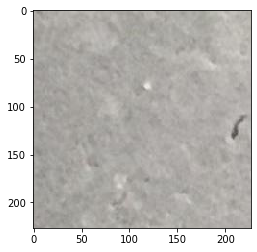

In [7]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
plt.imshow(imread(img_paths[0]))

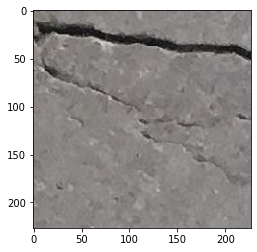

In [11]:
plt.imshow(imread(img_paths[-1]))

# Data augmentation

In [6]:
# setting image dimensions
IMAGE_DIMS = (224, 224, 3)

# loading preprocessing function
prep_func = tf.keras.applications.vgg16.preprocess_input 
        
# importing pretrained model
vgg_model = tf.keras.applications.vgg16.VGG16(input_shape = IMAGE_DIMS,
                                              include_top = False, weights = 'imagenet')
        
# freezing layers in pretrained model
for layer in vgg_model.layers:
    layer.trainable = False

# training generator for augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = prep_func,
                                                                rotation_range = 10,  
                                                                zoom_range = 0.1, width_shift_range = 0.1,  
                                                                height_shift_range = 0.1, 
                                                                horizontal_flip = True, 
                                                                vertical_flip = True)  

# validation/testing generator for augmentation
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = prep_func)

# batch size for training
train_bs = 16

# loading training data in batches
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df, x_col = "Path",
                                                    y_col = "Label", target_size = (IMAGE_DIMS[1], 
                                                                                    IMAGE_DIMS[0]),
                                                    batch_size = train_bs, 
                                                    class_mode = 'binary')

# batch size for validation
val_bs = 16

# loading validation data in batches
val_generator = val_datagen.flow_from_dataframe(dataframe = val_df, x_col="Path",
                                                y_col = "Label", target_size = (IMAGE_DIMS[1], 
                                                                                IMAGE_DIMS[0]),
                                                batch_size = val_bs, 
                                                class_mode = 'binary',
                                                shuffle = False)

# batch size for testing
test_bs = 16
    
# loading test data in batches
test_generator = val_datagen.flow_from_dataframe(dataframe = test_df, x_col = "Path",
                                                 y_col = "Label", target_size = (IMAGE_DIMS[1], 
                                                                                 IMAGE_DIMS[0]),
                                                 batch_size = test_bs, 
                                                 class_mode = 'binary',
                                                 shuffle = False)

Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.


# Model architecture

In [7]:
# import keras.backend.tensorflow_backend as K
# with K.tf.device('/cpu:0'):
# defining a sequential model to learn 
clf_model = tf.keras.Sequential()

# adding pretrained model
clf_model.add(vgg_model)

# using global average pooling instead of flatten and global max pooling
clf_model.add(tf.keras.layers.GlobalAveragePooling2D())

clf_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
clf_model.add(tf.keras.layers.Dropout(0.3))

clf_model.add(tf.keras.layers.Dense(512, activation=tf.nn.relu))
clf_model.add(tf.keras.layers.Dropout(0.3))

clf_model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))

# model summary
clf_model.summary()

# compiling the model
clf_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy',
                  metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

# Model parameters

In [8]:
# calculating steps for train, validation and testing
steps_train = np.ceil(train_df.shape[0]/train_bs)
steps_val = np.ceil(val_df.shape[0]/val_bs)
steps_test = np.ceil(test_df.shape[0]/test_bs)

print("Steps for training:", str(steps_train) + ',', "validation:", str(steps_val) + ',', 
      "testing:", str(steps_test))

Steps for training: 1600.0, validation: 400.0, testing: 500.0


# Model training

In [ ]:
# training
history = clf_model.fit_generator(train_generator, steps_per_epoch = steps_train,
                                  validation_data = val_generator, epochs = 1,
                                  validation_steps = steps_val, verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
   5/1600 [..............................] - ETA: 20:48 - loss: 0.7217 - accuracy: 0.6250

# Model evaluation

In [ ]:
# evaluation
clf_eval = clf_model.evaluate_generator(test_generator, steps = steps_test, 
                                        verbose = 1)

In [10]:
# getting accuracy from evaluation
print("Accuracy on Test:", clf_eval[1])

Accuracy on Test: 0.9978749752044678
